<a href="https://colab.research.google.com/github/Yoseph-Zuskin/midaspy/blob/master/example/monthly_CPI_daily_stock_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mixed Frequency Time-Series Forecasting Tutorial Using MIDAS Regression

#### This library is still in alpha stage of development. To install, run the following command:

In [ ]:
#!pip install --user git+git://github.com/Yoseph-Zuskin/midaspy.git@master

#### Now that the library is installed, load it along with Pandas:

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from itertools import product
from midaspy.iolib import *
from midaspy.model import MIDASRegressor

#### Use the following functions to extract CSV file from zip files and load data from Statistics Canada:

In [3]:
from zipfile import ZipFile
from requests import get
from io import BytesIO
def extract_zip_from_url(link):
    """
    Extract ZIP from URL
    this function extracts the bytes data from within ZIP files that are found online
    
    Parameters
        link (str): URL link for the ZIP file
        
    Returns
        output (dict): dictionary of zipped files' bytes data
    """
    u=get(link)
    f=BytesIO() 
    f.write(u.content)
    input_zip=ZipFile(f)
    output={i:input_zip.read(i) for i in input_zip.namelist()}
    return output

In [4]:
def load_stats_can_data(pid,low_memory=False):
    """
    Load Statistics Canada Data
    custom function to load data directly from an online zip file into a pandas dataframe
    
    Parameters
        pid (str): product id for the Statistics Canada online data asset
        low_memory (bool): memory setting for the pandas.read_csv function
        
    Returns
        df (pandas.DataFrame): resulting dataframe of all variables from the data asset
    """
    # first extract the zip file from the Statistics Canada website using extract_zip_from_url
    online_zip=extract_zip_from_url('https://www150.statcan.gc.ca/n1/tbl/csv/{}-eng.zip'.format(pid))
    # then load the resulting csv file for the data asset and set the date to datetime64[ns] data type
    df=pd.read_csv(BytesIO(online_zip['{}.csv'.format(pid)]),parse_dates=[0],low_memory=low_memory)
    df=df[df.iloc[:,1]=='Canada'] # filter the data asset to exclude data related to the territories
    variables=list(set(df.iloc[:,3])) # define list of variable types as they appear in the 4th column
    variable_series={} # store each variable series in this temporary dictionary instance
    for v in variables: # iterable over all the variables in this data asset
        series=df[df.iloc[:,3]==v].set_index(df.columns[0]).VALUE # filter dataframe for the variable
        series.rename(v,inplace=True) # rename the series to what Statistics Canada refers to it as
        variable_series[v]=series # store the resulting series in the temporary dictionary instance
    df=pd.DataFrame() # create dataframe to store all combined series
    for v in variables: # iterate over each variable and merge it as this works when pd.concat may fail
        df=pd.merge(right=df,left=variable_series[v],right_index=True,left_index=True,how='outer')
    return df        

### Part 1: Load Raw Data

In [5]:
# Load the Canadian Consumer Price Index data frm Statistics Canada
cpi_df=load_stats_can_data('10100106')
col='Consumer Price Index (CPI) inversely weighted by volatility and is adjusted to exclude the effect of changes in indirect taxes (CPIW) (year-over-year percent change)'
cpi_df=cpi_df[~cpi_df.index.duplicated(keep='first')][col]

In [6]:
# load the S&P/TSX Composite index historical daily data from Yahoo Finance
tsx=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/%5EGSPTSE?'+\
                'period1=-315619200&period2={}&interval=1d&events=history'.format(
                (pd.Timestamp.today()-pd.Timestamp("1970-01-01"))//pd.Timedelta('1s')),
               parse_dates=['Date'],index_col=0)

### Part 2: Explore & Process the Data

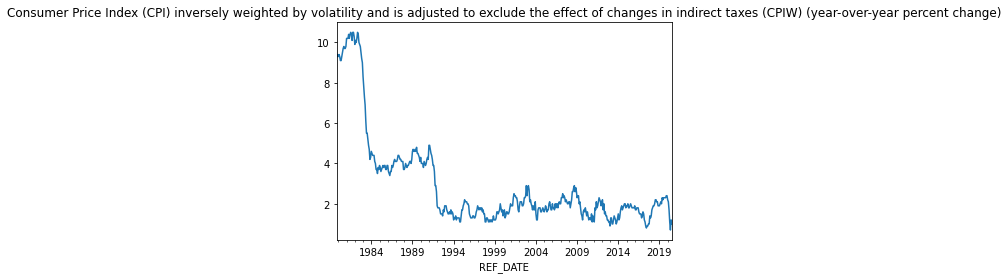

In [7]:
cpi_df.plot(title=col)

In [8]:
# the TSX data exists only for non-holiday weekdays but to keep all months' data comparable
# let's assume that there is no change in economic conditions on those days, so we can forward
# fill missing data over a continuous daily date range to address this issue by first creating
# an empty dataframe of all days in between the start and end dates of the available TSX data
continuous_daterange=pd.date_range(tsx.index[0],tsx.index[-1]).to_frame().drop(0,axis=1)
# then concatenate this continuous date range with the TSX data and do a forward fill
tsx=pd.concat([continuous_daterange,tsx],axis=1).ffill()
del continuous_daterange # delete the temporary continuous_daterange index

In [9]:
# it appears that the volume is zero until November 1984, so only daily data from 1985 onward will be used
tsx[tsx.Volume!=0].dropna().head()

,Open,High,Low,Close,Adj Close,Volume
1984-11-05,2369.100098,2389.800049,2368.800049,2389.800049,2383.731201,112400.0
1984-11-06,2400.899902,2423.000000,2400.899902,2423.000000,2416.846680,161600.0
1984-11-07,2423.899902,2427.000000,2412.899902,2413.800049,2407.670654,105500.0
1984-11-08,2409.399902,2419.100098,2407.199951,2415.199951,2409.066650,90400.0
1984-11-09,2421.100098,2425.800049,2416.199951,2416.500000,2410.363525,75700.0


### Part 3: Exploring the polynomial weighting methods

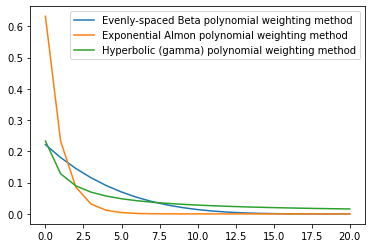

In [10]:
# these are the baseline weights for nlag observations using each of the three possible polynomial weighting methods
nlags = 21
pd.concat([
    pd.Series(BetaWeights(1., 5.).weights(nlags)).rename("Evenly-spaced Beta polynomial weighting method"),
    pd.Series(ExpAlmonWeights(-1., 0.).weights(nlags)).rename("Exponential Almon polynomial weighting method"),
    pd.Series(HyperbolicWeights(0.1).weights(nlags)).rename("Hyperbolic (gamma) polynomial weighting method")
], axis=1).plot()

In [11]:
list1 = np.linspace(-1.5, 1.5, 15).tolist()
list2 = np.linspace(-10, 10, 15).tolist()
beta_combos = list(product(list1, list2))

In [12]:
nlags = 21
beta_weightings = pd.DataFrame()
for combo in beta_combos:
    beta_weightings = pd.concat([beta_weightings,
                                pd.Series(BetaWeights(*combo).weights(nlags)).rename(str(combo))],
                               axis=1)

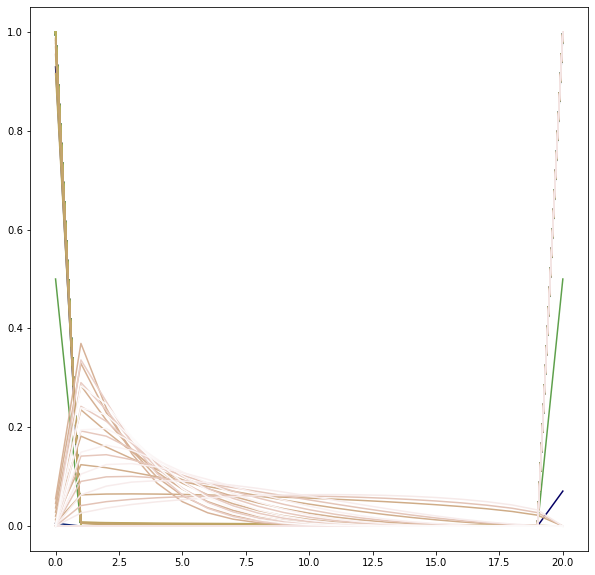

In [13]:
beta_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

In [14]:
list3 = np.linspace(-1.5, 1.5, 15).tolist()
expon_combos = list(product(list3, list3))

In [15]:
nlags = 21
expon_weightings = pd.DataFrame()
for combo in expon_combos:
    expon_weightings = pd.concat([expon_weightings,
                                  pd.Series(ExpAlmonWeights(*combo).weights(nlags)).rename(str(combo))],
                                 axis=1)

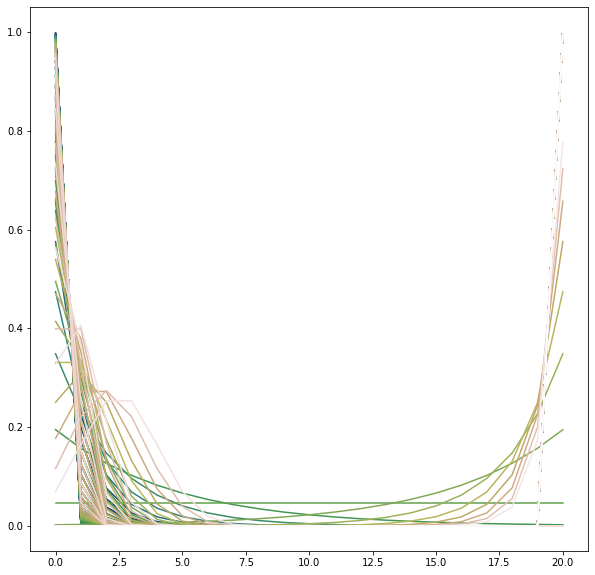

In [16]:
expon_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

In [17]:
nlags = 21
hyperbolic_weightings = pd.DataFrame()
for weight in np.linspace(-3, 3, 124).tolist():
    hyperbolic_weightings = pd.concat([hyperbolic_weightings,
                                       pd.Series(HyperbolicWeights(weight).weights(nlags)).rename(str(weight))],
                                      axis=1)

C:\Users\zuski\AppData\Roaming\Python\Python37\site-packages\midaspy\iolib.py:150: RuntimeWarning: invalid value encountered in true_divide
  g = gamma(u + self.theta) / (gamma(u + 1) * gamma(self.theta))


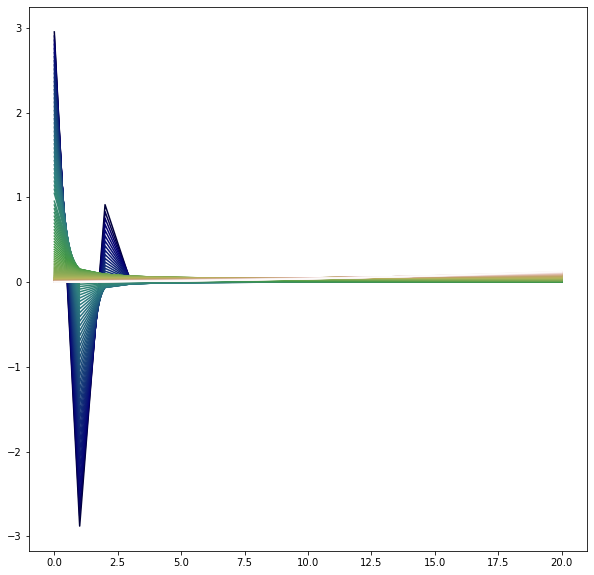

In [18]:
hyperbolic_weightings.plot(colormap="gist_earth",legend=False,figsize=[10,10])

### Part 4: Fit MIDAS Regressoion Model

In [19]:
# Select training data up to end of 2019
x1 = tsx['Adj Close'].rename('TSX_7d_pct_change')['1983-11-01':'2019-12-01'].pct_change(7).dropna()
x2 = tsx['Adj Close'].rename('TSX_14d_pct_change')['1983-11-01':'2019-12-01'].pct_change(14).dropna()
x3 = tsx['Adj Close'].rename('TSX_21d_pct_change')['1983-11-01':'2019-12-01'].pct_change(21).dropna()
x4 = tsx['Adj Close'].rename('TSX_28d_pct_change')['1983-11-01':'2019-12-01'].pct_change(28).dropna()
y = cpi_df.rename('CPI_YoY')['1984-02-01':'2019-12-01']

In [20]:
model = MIDASRegressor(endog=y,exog=pd.concat([x1,x2,x3,x4],axis=1).loc['1983-11-30':],
                       xlag=30,ylag=1,poly='beta')

In [21]:
fit = model.fit() # this may take a few minutes depending on the data

C:\Users\zuski\AppData\Roaming\Python\Python37\site-packages\midaspy\iolib.py:66: RuntimeWarning: overflow encountered in power
  beta_vals = u ** (self.theta1 - 1) * (1 - u) ** (self.theta2 - 1)
C:\Users\zuski\AppData\Roaming\Python\Python37\site-packages\midaspy\iolib.py:68: RuntimeWarning: invalid value encountered in true_divide
  beta_vals = beta_vals / sum(beta_vals)


### Part 5: Evaluate Model Fit

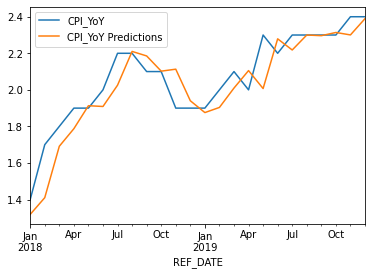

In [22]:
pd.concat([fit.orig_endog,fit.predict()], axis=1)[-24:].plot()

In [23]:
fit.score()

0.9669502783234388

In [24]:
fit.significance()

,coef,std err,t,P>|t|,0.025,0.975
Constant,0.044,0.022,1.998,0.046,0.001,0.087
TSX_7d_pct_change,-13.076,5.140,-2.544,0.011,-23.178,-2.974
TSX_14d_pct_change,9.266,3.511,2.640,0.009,2.366,16.167
TSX_21d_pct_change,0.710,0.603,1.178,0.240,-0.475,1.894
TSX_28d_pct_change,-1.778,0.736,-2.415,0.016,-3.226,-0.331
CPI_YoY t-1,0.978,0.009,110.655,0.000,0.960,0.995


### Part 6: Out-of-sampling predictions

In [25]:
# Select test data (2020-present)
x1_test = tsx['Adj Close'].rename('TSX_7d_pct_change')['2019-12-01':].pct_change(7).dropna()
x2_test = tsx['Adj Close'].rename('TSX_14d_pct_change')['2019-12-01':].pct_change(14).dropna()
x3_test = tsx['Adj Close'].rename('TSX_21d_pct_change')['2019-12-01':].pct_change(21).dropna()
x4_test = tsx['Adj Close'].rename('TSX_28d_pct_change')['2019-12-01':].pct_change(28).dropna()
y_test = cpi_df.rename('CPI_YoY')['2020-01-01':]

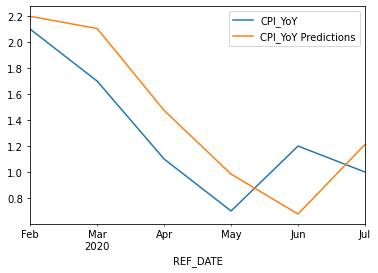

In [26]:
# Plot predictions
preds = fit.predict(endog=y_test,exog=pd.concat([x1_test,x2_test,x3_test,x4_test],axis=1))
preds.index = y_test.index[1:]
pd.concat([y_test[1:], preds], axis=1).plot()